## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

In [2]:
# Step through the list and search for chessboard corners
def getCalibrationParameters(listFileimage, listX, listY):
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    images = []
    for i in range(len(listFileimage)):
        fname = 'camera_cal/' + listFileimage[i]
        x = listX[i]
        y = listY[i]
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        objp = np.zeros((x*y,3), np.float32)
        objp[:,:2] = np.mgrid[0:x,0:y].T.reshape(-1,2)
        ret, corners = cv2.findChessboardCorners(gray, (x,y),None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img, (x,y), corners, ret)
        images.append(img)
        
    return objpoints, imgpoints, images

## And so on and so forth...

In [3]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [
            [1280-585, 445],   # top right
            [1280-  0, 720],   # bottom right
            [       0, 720],   # bottom left
            [     585, 445]    # top left

        ]
    )
    dst = np.float32(
        [
            [1280,   0],   # top right
            [1280, 720],   # bottom right
            [   0, 720],   # bottom left
            [   0,   0]    # top left
        ]
    )
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped


In [4]:
def pipeline(img, mtx, dist):
    
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    img_warped = warp(img)
    
    img = cv2.cvtColor(img_warped, cv2.COLOR_RGB2HLS)
    temp = img[:,:,2]
    s_channel = np.zeros((temp.shape[0], temp.shape[1], 3))
    s_channel[:,:,0] = 1-temp
    s_channel[:,:,1] = 1-temp
    s_channel[:,:,2] = 1-temp
    
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=5)
    sobel_magnitude = np.sqrt(np.multiply(sobelx,sobelx))
    scaled_sobel = np.uint8(255*sobel_magnitude/np.max(sobel_magnitude))

    sbinary = np.zeros_like(sobelx)
    sbinary[(scaled_sobel >= 20) & (scaled_sobel <= 200)] = 1
    
    acc = [0 for i in range(sbinary.shape[1])]
    for i in range(sbinary.shape[1]):
        for j in range(sbinary.shape[0]):
            if sbinary[j,i,0] > .4:
                acc[i] = acc[i] + 1

    y_max_left = np.argmax(np.array(acc[0:sbinary.shape[1]//2]))
    y_max_right = np.argmax(np.array(acc[sbinary.shape[1]//2:])) + sbinary.shape[1]//2
    
    x = []
    y = []
    for i in range(sbinary.shape[1]//2-30):
        if abs(i-y_max_left) > 180:
            continue
        for j in range(sbinary.shape[0]):
            if sbinary[j,i,0] > .4:
                x.append(float(j))
                y.append(float(i))
    poly_left = np.polynomial.polynomial.polyfit(x, y, 2)                
    
    x = []
    y = []
    for i in range(sbinary.shape[1]//2+30, sbinary.shape[1]):
        if abs(i-y_max_right) > 180:
            continue
        for j in range(sbinary.shape[0]):
            if sbinary[j,i,0] > .4:
                x.append(float(j))
                y.append(float(i))
    poly_right = np.polynomial.polynomial.polyfit(x, y, 2)    
    
    poly_img = img_warped
    for j in range(poly_img.shape[0]):
        y_left = poly_left[0] + poly_left[1]*float(j) + poly_left[2]*float(j)*float(j)
        y_right = poly_right[0] + poly_right[1]*float(j) + poly_right[2]*float(j)*float(j)
        for i in range(poly_img.shape[1]):
            if abs(y_left - float(i)) < 7:
                poly_img[j,i,0] = 0
                poly_img[j,i,1] = 0
                poly_img[j,i,2] = 0
            if abs(y_right - float(i)) < 7:
                poly_img[j,i,0] = 0
                poly_img[j,i,1] = 0
                poly_img[j,i,2] = 0
                
    return poly_img


In [5]:

objpoints, imgpoints, images = getCalibrationParameters(
    [
        'calibration1.jpg',  'calibration2.jpg',  'calibration3.jpg',
        'calibration4.jpg',  'calibration5.jpg',  'calibration6.jpg',
        'calibration7.jpg',  'calibration8.jpg',  'calibration9.jpg',
        'calibration10.jpg', 'calibration11.jpg', 'calibration12.jpg',
        'calibration13.jpg', 'calibration14.jpg', 'calibration15.jpg',
        'calibration16.jpg', 'calibration17.jpg', 'calibration18.jpg',
        'calibration19.jpg', 'calibration20.jpg'        
    ], 
    [
        9,9,9,    #  1  2  3 
        9,9,9,    #  4  5  6
        9,9,9,    #  7  8  9
        9,9,9,    # 10 11 12
        9,9,9,    # 13 14 15
        9,9,9,    # 16 17 18
        9,9       # 19 20
    ], 
    [
        5,6,6,    #  1  2  3
        6,5,6,    #  4  5  6 
        6,6,6,    #  7  8  9
        6,6,6,    # 10 11 12
        6,6,6,    # 13 14 15
        6,6,6,    # 16 17 18
        6,6       # 19 20
    ])





In [6]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (720, 1280),None,None)


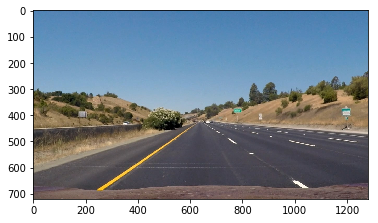

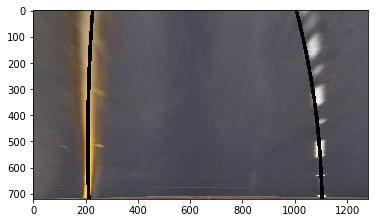

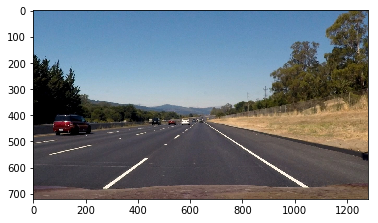

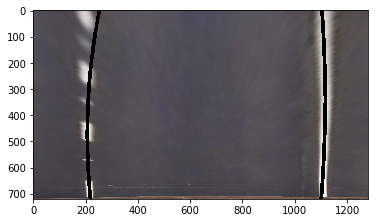

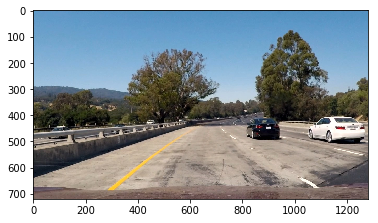

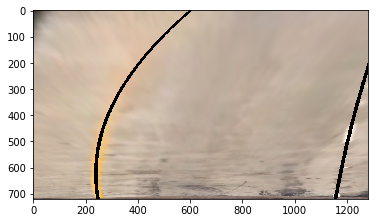

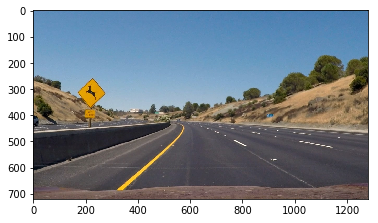

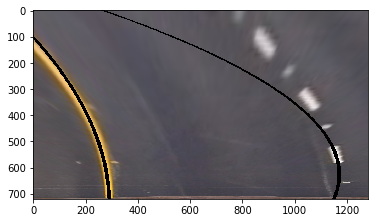

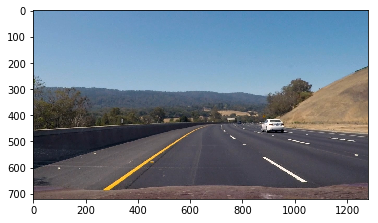

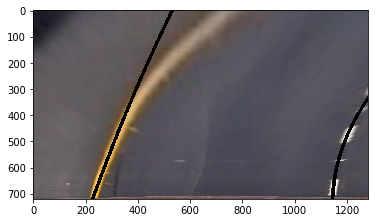

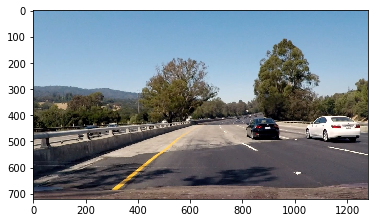

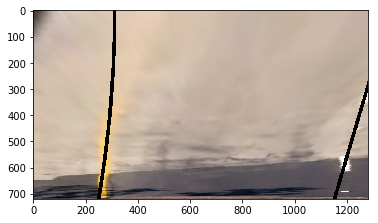

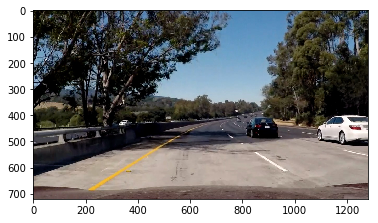

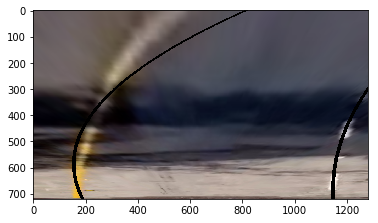

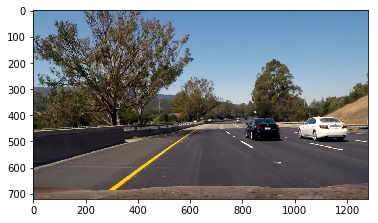

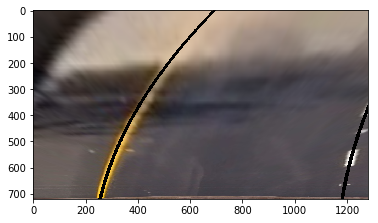

In [7]:
for fileimage in [
    'straight_lines1.jpg', 'straight_lines2.jpg', 'test1.jpg', 
    'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']:
    img = cv2.imread('test_images/' + fileimage)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    img_lane = pipeline(img, mtx, dist)
    plt.imshow(img_lane)
    plt.show()